## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt, transforms
import random
import pandas as pd
# from Load_Recording_Data import LoadRecordingData, Recording           # (Use this for old data)
from load_recording_data import LoadRecordingData#, Recording            # (Use this for new data)
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import pysindy as ps
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.integrate import quad
import tensorflow as tf
import keras
from fastdtw import fastdtw
import itertools
import copy

2024-02-08 13:10:17.988833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 13:10:18.840716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-08 13:10:18.840817: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-08 13:10:18.840827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpu_id = 1
tf.config.set_visible_devices(gpus[gpu_id], 'GPU')

## Load Data

In [3]:
# intrasTrain, extrasTrain, intrasTest, extrasTest = LoadRecordingData()
intrasTrainVal, extrasTrainVal, intrasTest, extrasTest = LoadRecordingData()
idx_train, idx_val = train_test_split(np.arange(len(intrasTrainVal)), test_size=0.20)#, random_state=10)

extrasTrain = extrasTrainVal[idx_train]
intrasTrain = intrasTrainVal[idx_train]
extrasVal = extrasTrainVal[idx_val]
intrasVal = intrasTrainVal[idx_val]

# dataset = LoadRecordingData()
# idx_train, idx_test = train_test_split(np.arange(len(intrasRaw)), test_size=0.20, random_state=42)

# extrasTrain = dataset['8k'].extras_training2
# intrasTrain = dataset['8k'].intras_training2
# extrasVal = dataset['8k'].extras_val2
# intrasVal = dataset['8k'].intras_val2

W5FebD1_10nM_Dofe_51_52_8000
W5FebD1_10nM_Dofe_57_58_8000
W5FebD1_10nM_Dofe_84_85_8000
W8FebD2_10nM_Dofe_57_47_8000
W8FebD2_10nM_Dofe_84_74_8000
W8FebD3_10nM_Dofe_24_14_8000
W8FebD3_10nM_Dofe_61_62_8000


## Helper functions

In [4]:
# Takes in a 1-dimensional array and a window size, and applies a moving
# average filter to data.
def moving_filter(data, window_size):
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        this_window = data[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    for i in range(window_size - 1):
        ind = len(data) - (window_size - i)
        moving_averages.append(np.mean(data[ind-window_size:ind]))

    return moving_averages

def mse(y, p):
    return np.mean((y-p)**2)

def mae(y, p):
    return np.mean(np.absolute(y-p))

def dtw(y, p):
    distances = []
    
    for i in range(len(y)):
        dist, _ = fastdtw(y[i], p[i])
        distances.append(dist)
        
    return np.mean(np.array(distances))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

### Smooth the data by applying moving filter

In [5]:
# Apply moving filter on intras and extras
# Training set
windowSize = 20
temp = []

for rec in intrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
intrasTrain = np.array(temp)
temp = []

for rec in extrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
extrasTrain = np.array(temp)

# Validation set
temp = []

for rec in intrasVal:
    temp.append(moving_filter(rec, windowSize))
    
intrasVal = np.array(temp)
temp = []

for rec in extrasVal:
    temp.append(moving_filter(rec, windowSize))
    
extrasVal = np.array(temp)


# Test set
temp = []

for rec in intrasTest:
    temp.append(moving_filter(rec, windowSize))
    
intrasTest = np.array(temp)
temp = []

for rec in extrasTest:
    temp.append(moving_filter(rec, windowSize))
    
extrasTest = np.array(temp)

### Function to extract features

In [6]:
def GetFeatures(intras, extras):
    XBefore = []
    XAfter = []
    YBefore = []
    YAfter = []
    windowSize = 20
    
#     featureNames = ['d2eAP', 'deAP', 'eAP']#, 'exp(d2eAP)', 'exp(deAP)', 'exp(eAP)']#, 'distFromMax', 'distFromMin']
#     s = [i for i in range(len(featureNames))]
#     combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
#     featureCombs = []
    
#     for comb in combs[1:]:
#         for tpl in comb:
#             name = ""

#             for ind in tpl:
#                 name += "*"+featureNames[ind]

#             featureCombs.append(name)
            
    t = np.array([i for i in range(len(extras[0]))])/len(extras[0])
    
    for i in range(len(extras)):
        iAP = intras[i]
        diAP = np.array(moving_filter(np.gradient(iAP), windowSize))
        d2iAP = np.array(moving_filter(np.gradient(diAP), windowSize))

        eAP = extras[i]
        eAP[:1500][eAP[:1500] < np.mean(eAP)] = np.mean(eAP)
        deAP = np.array(moving_filter(np.gradient(eAP), windowSize))
        d2eAP = np.array(moving_filter(np.gradient(deAP), windowSize))
        
        breakInd = np.argmax(eAP[:1500])#+300
            
#         iAP = intras[i]
#         diAP = np.gradient(iAP)
#         d2iAP = np.gradient(diAP)

#         eAP = extras[i]
#         deAP = np.gradient(eAP)
#         d2eAP = np.gradient(deAP)
        
        overlap = 10
        breakInd += overlap
        featureMatrix1 = [d2eAP[:breakInd], deAP[:breakInd], eAP[:breakInd], t[:breakInd]]
        breakInd -= overlap
        featureMatrix2 = [d2eAP[breakInd:], deAP[breakInd:], eAP[breakInd:], t[breakInd:]]
        
        
        XBefore.append(np.array(featureMatrix1).T)
        XAfter.append(np.array(featureMatrix2).T)
        YBefore.append(iAP[:breakInd+overlap])
        YAfter.append(iAP[breakInd:])
        
#     XBefore = np.array(XBefore)
#     XAfter = np.array(XAfter)
#     Y = np.array(Y)
     
    return XBefore, XAfter, YBefore, YAfter

### Extract features from train, val and test data

In [7]:
XBefore, XAfter, YBefore, YAfter = GetFeatures(intrasTrain, extrasTrain)

In [8]:
X_valBefore, X_valAfter, Y_valBefore, Y_valAfter = GetFeatures(intrasVal, extrasVal)

In [9]:
X_testBefore, X_testAfter, Y_testBefore, Y_testAfter = GetFeatures(intrasTest, extrasTest)

## SINDy piecewise modeling

In [10]:
differentiation_method = ps.FiniteDifference(order=2)

feature_library = ps.PolynomialLibrary(degree=2)
#feature_library = ps.FourierLibrary(n_frequencies=5)

library_functions = [lambda x: np.exp(x)]
library_function_names = [lambda x: "exp(" + x + ")"]
custom_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)

generalized_library = ps.GeneralizedLibrary([feature_library, custom_library])

# optimizer = ps.STLSQ(threshold=0.2, alpha=0.5)
optimizer = ps.SR3(threshold=0.1, thresholder="l2")
# optimizer = ps.SR3(trimming_fraction=0.1)
# optimizer = ps.SSR(alpha=0.05)
# optimizer = ps.SSR(alpha=0.05, criteria="model_residual")
# optimizer = ps.SSR(alpha=0.05, criteria="model_residual", kappa=1e-3)
# optimizer = ps.FROLS(alpha=0.05)
# optimizer = ps.FROLS(alpha=0.05, kappa=1e-7)
# optimizer = Lasso(alpha=2, max_iter=2000, fit_intercept=False)

discrete = False

model1 = copy.deepcopy(ps.SINDy(differentiation_method=differentiation_method,
    feature_library=feature_library, #generalized_library,
    optimizer=optimizer,
    discrete_time=discrete))

model2 = copy.deepcopy(ps.SINDy(differentiation_method=differentiation_method,
    feature_library=feature_library, #generalized_library,
    optimizer=optimizer,
    discrete_time=discrete))

model1.fit(XBefore, t=1, x_dot=YBefore, multiple_trajectories=True)
model2.fit(XAfter, t=1, x_dot=YAfter, multiple_trajectories=True)

model1.print()
model2.print()

(x0)' = 0.077 1 + 186.970 x0 + 32.184 x1 + 0.691 x2 + -0.120 x3 + 7893.682 x0^2 + 6116.990 x0 x1 + -33.923 x0 x2 + -2136.324 x0 x3 + 610.992 x1^2 + 12.480 x1 x2 + -384.371 x1 x3 + -1.247 x2^2 + 0.672 x2 x3 + 5.175 x3^2
(x0)' = 1.351 1 + -1172.803 x0 + -66.207 x1 + -1.553 x2 + -2.083 x3 + -5312685.800 x0^2 + -571220.518 x0 x1 + 3000.028 x0 x2 + 732.650 x0 x3 + -17165.414 x1^2 + 120.053 x1 x2 + -9.950 x1 x3 + 1.713 x2^2 + 2.005 x2 x3 + 0.676 x3^2


### Evaluate model on test data

In [11]:
# Prediction of 2nd derivative

# predD2Before = np.array(model1.predict(X_testBefore, multiple_trajectories=True))
# predD2After = np.array(model2.predict(X_testAfter, multiple_trajectories=True))
# predD2 = []

# overlap = len(predD2Before[0]) + len(predD2After[0]) - len(extrasTrain[0])

# for i in range(len(predD2Before)):
#     predD2.append(np.concatenate((predD2Before[i][:-overlap], predD2After[i]), axis=0))
    
# predD2 = np.array(predD2)    
# predD2 = np.reshape(predD2, predD2.shape[:2])



# Prediction of first derivative

# predD1Before = np.array(model1.predict(X_testBefore, multiple_trajectories=True))
# predD1After = np.array(model2.predict(X_testAfter, multiple_trajectories=True))
# predD1 = []

# overlap = len(predD1Before[0]) + len(predD1After[0]) - len(extrasTrain[0])

# for i in range(len(predD1Before)):
#     predD1.append(np.concatenate((predD1Before[i][:-overlap], predD1After[i]), axis=0))
    
# predD1 = np.array(predD1)    
# predD1 = np.reshape(predD1, predD1.shape[:2])
# predD1 = np.cumsum(predD2, axis=1)



# Prediction of iAP

predBefore = np.array(model1.predict(X_testBefore, multiple_trajectories=True))
predAfter = np.array(model2.predict(X_testAfter, multiple_trajectories=True))
pred = []

overlap = len(predBefore[0]) + len(predAfter[0]) - len(extrasTrain[0])

for i in range(len(predBefore)):
    pred.append(np.concatenate((predBefore[i][:-overlap], predAfter[i]), axis=0))
    
pred = np.array(pred)    
pred = np.reshape(pred, pred.shape[:2])
# pred = np.cumsum(predD1, axis=1)


# yd1 = []

# for i in range(len(Y_testBefore)):
#     yd1.append(np.concatenate((Y_testBefore[i][:-overlap], Y_testAfter[i]), axis=0))
    
# yd1 = np.array(yd1)

y = intrasTest #np.cumsum(yd1, axis=1)

print("MSE on test d1 with reg_selected", mse(pred, y))
print("MAE on test d1 with reg_selected", mae(pred, y))
print("DTW on test d1 with reg_selected", dtw(pred, y))

MSE on test d1 with reg_selected 0.00561343205416548
MAE on test d1 with reg_selected 0.05398182271662862
DTW on test d1 with reg_selected 87.59678197595903


In [27]:
# 311, 126, 280
import pickle
iAP_sindy_piecewise = {}

### Prediction plots for a random recording from the test set

In [11]:
predBefore = np.array(model1.predict(XBefore, multiple_trajectories=True))
predAfter = np.array(model2.predict(XAfter, multiple_trajectories=True))
predTrain = []

overlap = len(predBefore[0]) + len(predAfter[0]) - len(extrasTrain[0])

for i in range(len(predBefore)):
    predTrain.append(np.concatenate((predBefore[i][:-overlap], predAfter[i]), axis=0))
    
predTrain = np.array(predTrain)    
predTrain = np.reshape(predTrain, predTrain.shape[:2])

881


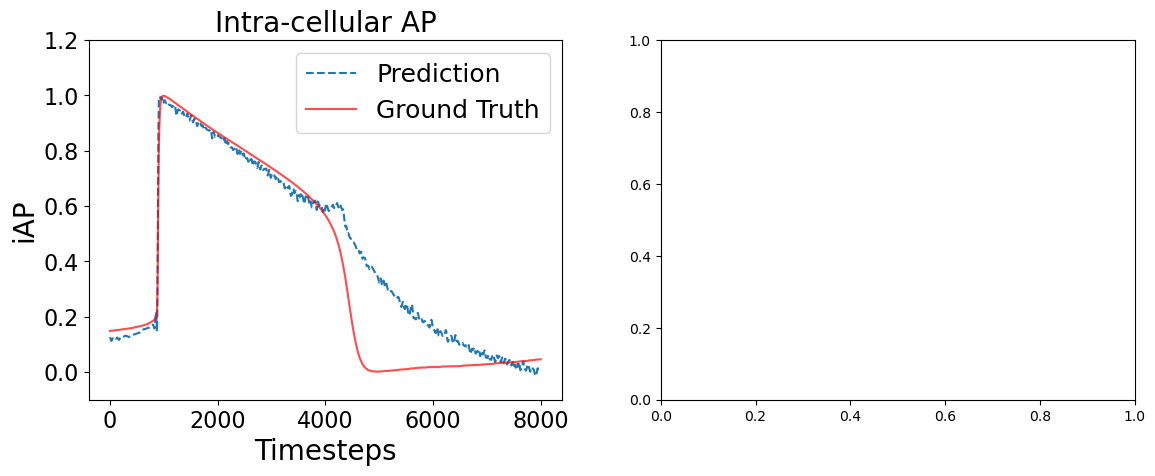

In [41]:
ind = 881#random.randint(0, len(predTrain)) # 280, 391, 881, 507, 34, 1157 in train
print(ind)
gt = intrasTrain[ind]
out = predTrain[ind]

out = moving_filter(out, windowSize)
out = moving_filter(out, windowSize)

transparency = 0.7
fig0, ax0 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig0.tight_layout(pad=4)

# Plot iAP prediction
ax0[0].plot(out, linestyle='dashed')
ax0[0].plot(gt, alpha=transparency, color='red')
ax0[0].legend(['Prediction', 'Ground Truth'], prop={'size': 18})
ax0[0].title.set_text("Intra-cellular AP")
ax0[0].title.set_fontsize(20)
ax0[0].set_xlabel("Timesteps", fontsize=20)
ax0[0].set_ylabel("iAP", fontsize=20)
ax0[0].set_ylim([-0.1, 1.2])
ax0[0].tick_params(axis='x', labelsize=16)
ax0[0].tick_params(axis='y', labelsize=16)

In [34]:
iAP_sindy_piecewise[280] = [out, gt]

In [35]:
iAP_sindy_piecewise

{311: [[0.11461854144308195,
   0.1149713035068067,
   0.1153486128001682,
   0.11573492509959857,
   0.11613682115428484,
   0.11654784131655975,
   0.11696432041385114,
   0.11739848339521194,
   0.11784367792229508,
   0.1182926467700673,
   0.11873798150857795,
   0.1191659133401864,
   0.11957042675466797,
   0.1199514371337381,
   0.12031148932796365,
   0.12065473104297542,
   0.12096916285971585,
   0.12124005049968993,
   0.1214749073677009,
   0.12167458888104181,
   0.12183615874090062,
   0.1219586648784392,
   0.12205470769248539,
   0.12214488659969192,
   0.122225991138362,
   0.12229361929571678,
   0.1223465580741965,
   0.12236946743696449,
   0.12236459532190444,
   0.12234405160793935,
   0.12231281114781525,
   0.12227845391229861,
   0.12224173214562577,
   0.12219932330934942,
   0.12214827368276297,
   0.12209089387336322,
   0.12203561577972825,
   0.12199371633888978,
   0.12196437531098163,
   0.121957404851244,
   0.12198106376644158,
   0.12203718119805178,

In [36]:
with open('iAP_sindy_piecewise.pkl', 'wb') as fl:
    pickle.dump(iAP_sindy_piecewise, fl);